## 4. Анализ результатов A/B-тестирования: кумулятивные метрики

ОПИСАНИЕ ЗАДАЧИ

Проводится A/B-тестирование для двух вариантов рекомендаций сопутствующих товаров в профиле товара некоторого интернет-магазина. 

Вариант 1. Дополнительные товары рекомендуются на основе статистических данных уже совершённых покупок — товары, которые другие пользователи часто покупают с основным. 

Вариант 2. Дополнительные товары рекомендуются на основе совершённых пользователем ранее покупок с помощью рекомендательной системы, построенной на основе гибридного подхода.

Варианты сравниваются по доле пользователей, которые добавляют хотя бы один из предложенных товаров в корзину (метрикой является конверсия действия «добавить в корзину сопутствующий товар»).

Для этого пользователи были разделены на две группы. 

Контрольной (группе А) доступен первый вариант рекомендаций.
Тестовой (группе B) доступен второй вариант. 
Предполагается, что все условия и принципы проведения A/B-теста были соблюдены, то есть:

✔️ выборка имеет достаточный для принятия решения объём;

✔️ выбран достаточный интервал времени для тестирования;

✔️ группы максимально сбалансированы;

✔️ внешнее вмешательство минимально.

Итак, в результате проведения A/B-тестирования были получены следующие данные:



In [8]:
# Импорт библиотек
from pathlib import Path
from warnings import filterwarnings
import os
import sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Скрывает INFO и WARNING, оставляет только ERROR
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0' # Отключить oneDNN сообщения

# Автоматическое определение пути к текущему окружению conda
conda_prefix = os.environ.get('CONDA_PREFIX')
if conda_prefix:
    os.environ['XLA_FLAGS'] = f'--xla_gpu_cuda_data_dir={conda_prefix}'

# --- 2. Включение ускорения Intel для CPU --- scikit-learn
try:
    from sklearnex import patch_sklearn, config_context
    patch_sklearn()
    print('Intel Extension для scikit-learn успешно активирован')
except (ImportError, ModuleNotFoundError, Exception) as e:
    print(f'Не удалось активировать Intel Extension для scikit-learn: {e}')
    print(f'Продолжаем работу без ускорения (это нормально)')


from IPython.display import display, Markdown
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from scipy.linalg import svd
from scipy.optimize import minimize, least_squares

import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy
import sklearn
import math

import time



Intel Extension для scikit-learn успешно активирован


Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


In [ ]:
filterwarnings("ignore")
# warnings.filterwarnings('ignore', category=UserWarning)
# warnings.filterwarnings('ignore', message='.*ConvergenceWarning.*')

plt.style.use('seaborn-v0_8') #стиль отрисовки seaborn
sns.set_style("whitegrid")
# %matplotlib inline

SEED = 42

# Проверка текущей рабочей директории
print(f"Текущая рабочая директория: {os.getcwd()}")

# Текущая рабочая директория (скорее всего .../IDE)
current_dir = os.getcwd()

# Относительный путь от корня проекта до папки с ноутбуком
# Обратите внимание: используем r'' для корректной обработки слешей и пробелов
relative_path_to_notebook = r'skillfactory/DS_PROD-4'

# Проверяем, не перешли ли мы уже в нужную папку (чтобы не было ошибок при перезапуске ячейки)
if not current_dir.endswith("DS_PROD-4"):
    # Собираем полный путь
    new_dir = os.path.join(current_dir, relative_path_to_notebook)
    
    # Меняем рабочую директорию
    try:
        os.chdir(new_dir)
        print(f"Рабочая директория изменена на: {os.getcwd()}")
    except FileNotFoundError:
        print("Ошибка: путь не найден. Проверьте правильность названий папок.")
else:
    print("Рабочая директория уже верная.")

Текущая рабочая директория: /home/pavel/IDE/skillfactory/DS_PROD-4
Рабочая директория уже верная.


In [10]:
ab_data = pd.read_csv('./data/ab_data.zip')
ab_data.head()

,user_id,timestamp,group,converted
0,851104,2017-01-21,A,0
1,804228,2017-01-12,A,0
2,661590,2017-01-11,B,0
3,853541,2017-01-08,B,0
4,864975,2017-01-21,A,1


 Итак, мы получили таблицу со следующими полями:

- user_id	идентификатор пользователя, зашедшего на сайт
- timestamp	дата события
- group	группа теста (контрольная или тестовая)
- converted	совершил пользователь целевое действие (нажатие кнопки «добавить в корзину» на сопутствующем товаре) или нет. 1 — да, 0

Посмотрим тип данных и содержание каждого столбца, для этого применим к датафрейму метод info():

In [11]:
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290482 entries, 0 to 290481
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    290482 non-null  int64 
 1   timestamp  290482 non-null  object
 2   group      290482 non-null  object
 3   converted  290482 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 8.9+ MB


Итак, в наших данных нет пропусков, однако нам нужно перевести столбец с информацией о дате события (timestamp) в формат datetime. Напомним: для этого мы можем воспользоваться функцией pandas to_datetime():

In [12]:
ab_data['timestamp'] = pd.to_datetime(ab_data['timestamp'], format='%Y-%m-%d')
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290482 entries, 0 to 290481
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   user_id    290482 non-null  int64         
 1   timestamp  290482 non-null  datetime64[ns]
 2   group      290482 non-null  object        
 3   converted  290482 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 8.9+ MB


В итоге мы получили таблицу, в которой отображены входы клиента на сайт (сессия) и его действия. Для того, чтобы получить показатель конверсии в группах на каждый день, нам необходимо предварительно сгруппировать наши данные по дате и группе и вычислить количество пользователей, заходивших на сайт, и суммарное количество совершённых целевых действий. 

Дополнительно для удобства сбросим индекс на сгруппированной таблице c помощью метода reset_index() и переименуем столбец user_id в users_count с помощью метода rename().

In [13]:
daily_data = ab_data.groupby(['timestamp','group']).agg({
    'user_id':'count',
    'converted':'sum'
}).reset_index().rename(columns={'user_id': 'users_count'})
daily_data.head()

,timestamp,group,users_count,converted
0,2017-01-02,A,2851,357
1,2017-01-02,B,2848,339
2,2017-01-03,A,6584,749
3,2017-01-03,B,6620,754
4,2017-01-04,A,6573,797


Примечание. Количество пользователей в день в контрольной и тестовой группе определяется как количество значений в столбце user_id в сгруппированных данных, а количество совершённых целевых действий — это просто сумма по столбцу converted (1 в строке означает положительный исход, то есть целевое действие было совершено, а 0 — отрицательный исход; просуммировав все 1 и 0 в группе, получим количество положительных исходов).

Для завершения этапа подготовки данных к анализу нам осталось рассчитать конверсию на каждый день проведения A/B-тестирования. Напомним: ежедневная конверсия рассчитывается как отношение числа посетителей сайта, выполнивших на нём какие-либо целевые действия в день, к ежедневному общему числу посетителей сайта, умноженная на 100 %:

$conv_{t} = \frac{N_{t}^{+}}{N_{t}} \times 100\ %$

 $N_{t}^{+}$ — количество посетителей сайта, выполнивших целевое действие в день ;

 $N_{t}$ — общее количество посетителей сайта в день ;
 
 $conv_{t}$ — конверсия в день .

### Задание 4.1

1 point possible (graded)

Рассчитайте конверсию на каждый день по приведённой формуле. Результат занесите в столбец conversion. Чему была равна конверсия (в процентах) в группе А 5 января 2017 года? Ответ округлите до второго знака после запятой.

In [17]:
# Calculate conversion
daily_data['conversion'] = (daily_data['converted'] / daily_data['users_count']) * 100

# Filter for Group A on 2017-01-05
target_date = pd.to_datetime('2017-01-05')
result = daily_data[(daily_data['timestamp'] == target_date) & (daily_data['group'] == 'A')]

print("Conversion for Group A on 2017-01-05:")
print(result[['timestamp', 'group', 'conversion']])
print(f"Rounded result: {result['conversion'].iloc[0]:.2f}")

Conversion for Group A on 2017-01-05:
   timestamp group  conversion
6 2017-01-05     A   12.322792
Rounded result: 12.32


Вычислив ежедневную конверсию, мы получим следующую таблицу:

In [18]:
display(daily_data.head())

,timestamp,group,users_count,converted,conversion
0,2017-01-02,A,2851,357,12.521922
1,2017-01-02,B,2848,339,11.903090
2,2017-01-03,A,6584,749,11.376063
3,2017-01-03,B,6620,754,11.389728
4,2017-01-04,A,6573,797,12.125361


### ВИЗУАЛЬНЫЙ АНАЛИЗ КОНВЕРСИИ В ГРУППАХ

Нам необходимо ответить на вопрос: в какой группе (А или B) показатель конверсии был выше, и на этой основе принять решение о том, какой из вариантов более эффективный. 

Давайте построим диаграмму boxplot для сравнения параметров распределения ежедневной конверсии по группам. 

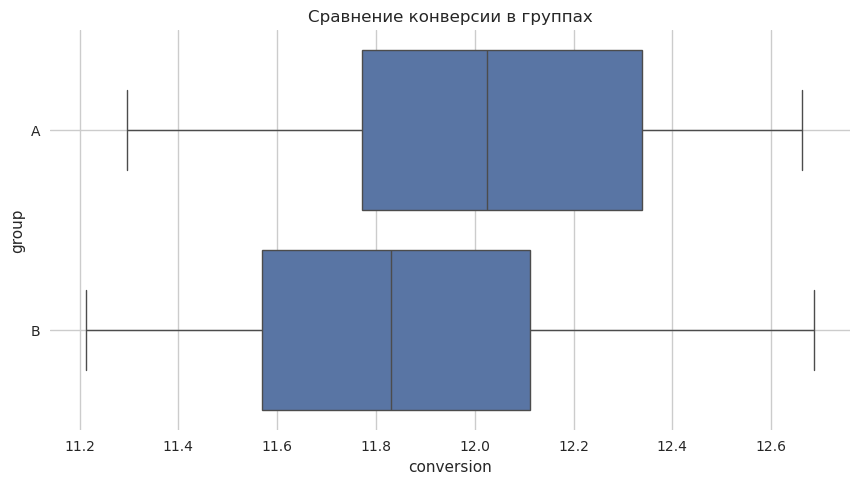

In [19]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4)) 
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1]) 
# строим boxplot для conversion по признаку group
sns.boxplot(data=daily_data, x='conversion', y='group', ax=ax) 
# задаём подпись к графику
ax.set_title('Сравнение конверсии в группах')
# задаём отображение сетки
ax.grid(True);

Что можно сказать исходя из этого графика? Во-первых, медианное значение ежедневной конверсии в группе А, выше, чем в группе B. Во-вторых, разброс конверсии в группе B несколько больше, чем в группе A.

Тут неопытный специалист воскликнет: версия рекомендаций А лучше, чем версия B (медиана конверсии варианта А больше, да и разброс поменьше, то есть конверсия более стабильна) — и завершит эксперимент. 

Но выводы делать ещё рано! И сейчас попробуем понять, почему. 

Примечание. Прежде чем делать выводы по визуальному представлению данных, всегда обращайте внимание на численные значения показателей. Они могут различаться в масштабе графика, но на практике разница между ними не будет иметь значения. Также всегда стоит убедиться, что в данных нет выбросов (базовый вариант — сравнить медиану и среднее между собой). Далее мы ещё поговорим о стабилизации показателя во времени.

Давайте вычислим средний и медианный показатель конверсии в контрольной и тестовой группе и умножим результат на 100 (получим результат в процентах):

In [20]:
conversion_piv = daily_data.groupby('group')['conversion'].agg(
    ['mean', 'median']
)
display(conversion_piv)

,mean,median
group,,
A,12.032876,12.024261
B,11.872697,11.829582


Из полученной таблицы видно, что медиана и среднее в каждой группе практически совпадают. При этом разница между показателями в группах менее 0.3 %! 

Возникает вопрос: а значима ли вообще такая разница в показателях или она обусловлена случайностью, и варианты A и B одинаково эффективны по метрике конверсии?

Прежде чем отвечать на этот вопрос, нам нужен ответ на другой вопрос: а стабилен ли показатель конверсии в группах во времени или он колеблется как «уж на сковородке»? 

Примечание. Вопрос о стабильности метрик является обязательным. Прогонять результаты через статистические тесты можно только после того, как вы убедитесь, что разница в ваших показателях стабилизировалась во времени. Это связано с проблемой подглядывания, речь о которой пойдёт ниже.

Тут нам помогут кумулятивные метрики.

### КУМУЛЯТИВНЫЕ МЕТРИКИ

В течение всего теста рекомендуется отслеживать поведение целевых метрик. Для этого чаще всего используются кумулятивные метрики.

Кумулятивная метрика — это отображение целевой метрики, когда вы отслеживаете её поведение за каждый день — накопленным итогом по дням. 

Почему это важно?

Ранее мы говорили, что для принятия решения в A/B-тестировании требуется большой объём данных, что соотносится с законом больших чисел: чем больше данных — тем ближе получаемый результат к математическому ожиданию (истинному среднему). 

Вспомните пример про подбрасывание монетки. Если подбросить монетку 10 раз, то велика вероятность, что один из двух результатов будет значительно превышать второй. Но если подбросить её 1 000 раз, то результаты компенсируют друг друга, и мы увидим, что итог крайне близок к разделению 50/50 (количество выпавших орлов и решек будет практически одинаковым).

Так же и в A/B-тестировании: с самого начала любой из вариантов может показывать лучшие результаты, и статистическая значимость может быть достигнута уже в первые дни теста. Это явление называется проблемой подглядывания.

Важно! Не стоит торопиться: как минимум дождитесь накопления запланированных объёмов выборки и длительности теста. Но и тут не стоит заканчивать тест — проверьте, стабилизировались ли метрики!

То есть в начале теста любой полученный за день результат будет оказывать сильное влияние на результат теста. Но со временем данные будут накапливаться, и доля получаемых за день данных будет всё меньше и меньше воздействовать на уже накопленный результат. 

Как видите, в начале данные подвержены сильному колебанию, но со временем они выравниваются.

Примечание. Кумулятивная метрика считается стабилизированной, когда на графике прекращаются резкие пики и спады показателя, и линия постепенно выравнивается в горизонтальную прямую.

Важно! Принимать какие-либо решения стоит только после того, как метрика стабилизируется!

Согласно центральной предельной теореме и закону больших чисел, с увеличением объёма данных метрика стабилизируется и будет стремиться к реальному среднему. 

Примечание. В качестве кумулятивной метрики можно считать не только конверсию, но и выручку, средний чек, количество заказов, процент негативных комментариев, точность модели и так далее.

Итак, давайте применим новые знания к нашим данным и вычислим кумулятивную конверсию, а затем построим её график. 

Но для начала ради эксперимента посмотрим, как вообще изменялись показатели ежедневной конверсии в каждой группе во времени. Для этого построим линейные графики для каждой группы: по оси абсцисс отложим дату, а по оси ординат — показатель конверсии:

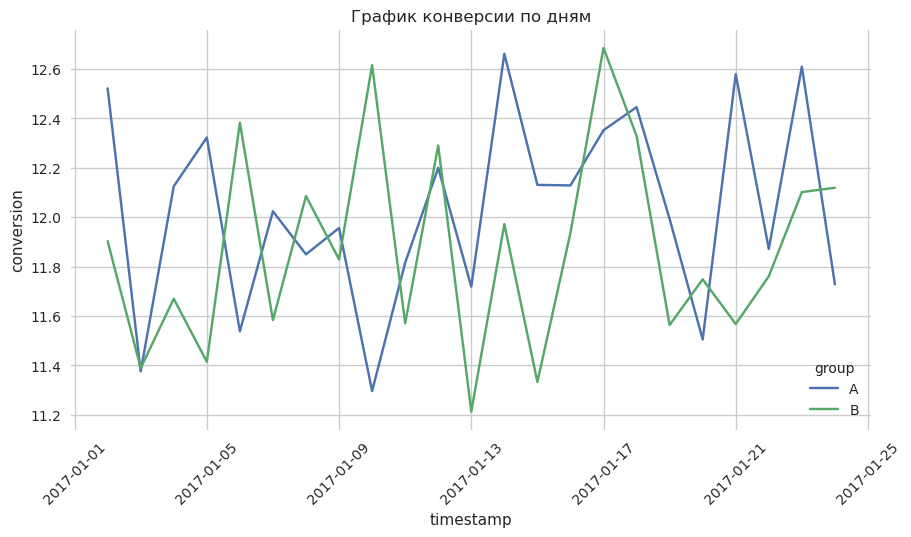

In [21]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для конверсии во времени в каждой группе
sns.lineplot(
    data=daily_data,
    x='timestamp',
    y='conversion',
    hue='group', 
    ax=ax
)
# задаём подпись к графику
ax.set_title('График конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation=45)
# задаём отображение сетки
ax.grid(True);

Что можно сказать по такому графику? Да практически ничего! Конверсия у обеих групп «скачет» день ото дня. Понять, какая из групп лучше, — практически невыполнимая задача. 

Именно поэтому и принято смотреть график кумулятивной конверсии, где за каждый день отображаются данные накопленным итогом.

Для расчёта кумулятивного показателя суммы в Pandas есть специальный метод cumsum(). Давайте посмотрим, как он работает — сначала на данных о ежедневном количестве посетителей для группы А. 

Выберем данные для группы А и создадим в полученной таблице новый столбец cum_users_count, в который запишем результат работы метода cumsum() по столбцу users_count:

In [22]:
# выделяем данные группы А
daily_data_a = daily_data[daily_data['group'] == 'A']
# считаем кумулятивное количество посетителей
daily_data_a.loc[:, 'cum_users_count'] = daily_data_a['users_count'].cumsum()
# выводим время, количество посетителей и кумулятивное количество посетителей
display(daily_data_a[['timestamp', 'users_count', 'cum_users_count']].head())

,timestamp,users_count,cum_users_count
0,2017-01-02,2851,2851
2,2017-01-03,6584,9435
4,2017-01-04,6573,16008
6,2017-01-05,6419,22427
8,2017-01-06,6604,29031


Обратите внимание, что в столбце с кумулятивной суммой за 2017-01-03 указано 9 435 пользователей. Сложите данные за 2017-01-02 и 2017-02-03 из столбца users_count — получите те же 9 435. Аналогично и для других дней. 

То есть кумулятивная сумма — это накопительная сумма; каждое её значение — это результат сложения показателя за предыдущие дни с показателем за текущий день. 

Кумулятивную сумму можно записать в виде рекурсивной формулы:

$$S_{t}=S_{t-1}+x_{t}$$


 $x_{t}$ — значение показателя в день t;
 $S_{t}$ — значение суммы в день t.

?Как сделать такой расчёт для двух групп (А и B) сразу? Воспользуемся методом groupby: сгруппируем данные по признаку группы, и в каждой группе будем вычислять кумулятивные суммы признаков количества посетителей (users_count) и количества совершённых целевых действий (converted). 

После этого рассчитаем кумулятивную конверсию — это отношение ежедневной кумулятивной суммы количества посетителей к ежедневной кумулятивной сумме количества совершённых целевых действий:

In [23]:
# вычисляем кумулятивную сумму количества посетителей
daily_data['cum_users_count'] = daily_data.groupby(['group'])['users_count'].cumsum()
# вычисляем кумулятивную сумму количества совершённых целевых действий
daily_data['cum_converted'] = daily_data.groupby(['group'])['converted'].cumsum()
# вычисляем кумулятивную конверсию
daily_data['cum_conversion'] = daily_data['cum_converted']/daily_data['cum_users_count'] * 100
display(daily_data.head())

,timestamp,group,users_count,converted,conversion,cum_users_count,cum_converted,cum_conversion
0,2017-01-02,A,2851,357,12.521922,2851,357,12.521922
1,2017-01-02,B,2848,339,11.903090,2848,339,11.903090
2,2017-01-03,A,6584,749,11.376063,9435,1106,11.722311
3,2017-01-03,B,6620,754,11.389728,9468,1093,11.544149
4,2017-01-04,A,6573,797,12.125361,16008,1903,11.887806


А теперь построим графики кумулятивной конверсии по дням в каждой группе:

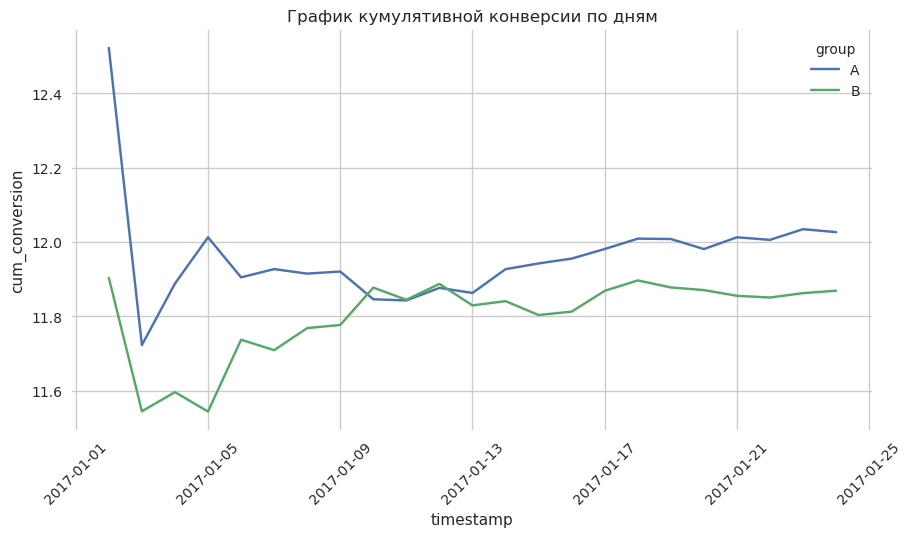

In [24]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='timestamp', y='cum_conversion', data=daily_data, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

Что можно сказать теперь? До 2017-01-09 конверсия была нестабильна, но после 2017-01-11 резкие скачки прекратились (кривая графика переходит в прямую). Судя по графику, конверсия группы B стабильно хуже конверсии группы А на всём промежутке времени. 

Обратите внимание на различие в конверсии в первые дни теста: тут наглядно отображена проблема подглядывания, когда статистическая значимость ошибочно могла быть достигнута уже в самом начале теста.

На основании стабилизированного кумулятивного графика мы можем сделать вывод, что длительность эксперимента была достаточной для того, чтобы судить о статистической значимости разности между показателем конверсии в группах.

⭐️ Значит, мы можем переходить к проведению статистических тестов. Но прежде предлагаем решить несколько заданий.

# Задания

Вводные данные для задач 4.6–4.9

Проводится A/B-тестирование для двух вариантов дизайна сайта. Результаты тестирования собраны в двух файлах (данные для группы А и для группы B).

In [25]:
sample_a = pd.read_csv('data/ab_test-redesign_sample_a.zip')
sample_b = pd.read_csv('data/ab_test-redesign_sample_b.zip')

display(sample_a.head())
display(sample_b.head())

,date,cid,transactions,revenue,group
0,2020-11-06,1.001648e+09,0,0,A
1,2020-11-06,1.001936e+09,0,0,A
2,2020-11-06,1.003214e+08,0,0,A
3,2020-11-06,1.004393e+09,0,0,A
4,2020-11-06,1.006382e+09,0,0,A


,date,cid,transactions,revenue,group
0,2020-11-06,1.000135e+09,0,0,B
1,2020-11-06,1.001648e+09,0,0,B
2,2020-11-06,1.003214e+08,0,0,B
3,2020-11-06,1.003652e+09,0,0,B
4,2020-11-06,1.003833e+09,0,0,B


Вводные данные для задач 4.6–4.9

Проводится A/B-тестирование для двух вариантов дизайна сайта. Результаты тестирования собраны в двух файлах (данные для группы А и для группы B).

``` python
sample_a = pd.read_csv('data/ab_test-redesign_sample_a.zip')
sample_b = pd.read_csv('data/ab_test-redesign_sample_b.zip')

display(sample_a.head())
display(sample_b.head())
```

Каждая таблица имеет следующие поля:

date — дата наблюдения;

cid — идентификатор посетителя;

transactions — количество совершённых целевых действий (транзакций);

revenue — сумма покупки;

group — группа (тестовая — А, контрольная — B).

Используйте эти данные для ответа на следующие вопросы.

### Задание 4.6

3 points possible (graded)

Постройте таблицу со следующими ежедневными показателями:

количество посетителей сайта;
суммарное число транзакций;
общая сумма покупок (выручка).

Для этого сгруппируйте данные по признаку date, предварительно преобразовав его к типу datetime.

Чему равны значения ежедневных показателей в группе А на 8 ноября 2020 года?

Количество посетителей сайта:

Суммарное число транзакций:

Общая сумма покупок:


Подсказка (1 из 2): Для преобразования столбца к типу datetime используйте функцию to_datetime() из библиотеки Pandas.
Подсказка (2 из 2): Количество посетителей сайта в день — агрегация с помощью метода count() по столбцу cid на сгруппированных данных. Суммарное число транзакций в день — агрегация с помощью метода sum() по столбцу transactions на сгруппированных данных. Выручка в день — агрегация с помощью метода sum() по столбцу revenue на сгруппированных данных. Для того чтобы производить группировку с разными агрегирующими, используется метод agg(), в который передаётся словарь, ключи которого — имена столбцов, значения — названия агрегирующих функций.

### Решение Задания 4.6

Расчет ежедневных показателей для группы А и получение значений на 8 ноября 2020 года.

In [26]:
# # Загрузка данных
# sample_a = pd.read_csv('data/ab_test-redesign_sample_a.zip')
# sample_b = pd.read_csv('data/ab_test-redesign_sample_b.zip')

# Преобразование даты
sample_a['date'] = pd.to_datetime(sample_a['date'])
sample_b['date'] = pd.to_datetime(sample_b['date'])

# Группировка по дате для группы А
daily_sample_a = sample_a.groupby('date').agg({
    'cid': 'count',
    'transactions': 'sum',
    'revenue': 'sum'
}).rename(columns={'cid': 'visitors_count', 'transactions': 'transactions_sum', 'revenue': 'revenue_sum'})

# Вывод значений на 8 ноября 2020 года
target_date_a = '2020-11-08'
print(f"Показатели для группы А на {target_date_a}:")
try:
    display(daily_sample_a.loc[target_date_a])
except KeyError:
    print("Данные за указанную дату не найдены.")
except NameError:
    # If display is not defined (e.g. running as script)
    print(daily_sample_a.loc[target_date_a])


Показатели для группы А на 2020-11-08:


visitors_count        3354
transactions_sum        25
revenue_sum         846051
Name: 2020-11-08 00:00:00, dtype: int64

### Задание 4.7

2 points possible (graded)

Добавьте в каждую из таблиц кумулятивные метрики:

- кумулятивное количество посетителей сайта;
- кумулятивное суммарное число транзакций;
- кумулятивная общая сумма покупок (кумулятивная выручка).

Рассчитайте кумулятивную конверсию действия покупки (в процентах) и кумулятивный средний чек (кумулятивная выручка/кумулятивное суммарное число транзакций).

Чему равна средняя кумулятивная конверсия в группах за весь период проведения A/B-теста? Ответ округлите до сотых, знаки процентов не вводите.


Подсказка (1 из 2): Для расчёта кумулятивного показателя используется синтаксис: data['column'] = data['column'].cumsum().
Подсказка (2 из 2): Кумулятивная конверсия рассчитывается следующим образом: cum_conversion=cum_transactions/cum_users_count.

### Решение Задания 4.7

Расчет кумулятивных метрик и средней кумулятивной конверсии.

In [27]:
# Группировка по дате для группы B (если еще не сделана)
daily_sample_b = sample_b.groupby('date').agg({
    'cid': 'count',
    'transactions': 'sum',
    'revenue': 'sum'
}).rename(columns={'cid': 'visitors_count', 'transactions': 'transactions_sum', 'revenue': 'revenue_sum'})

# Расчет кумулятивных метрик для группы А
daily_sample_a['cum_visitors'] = daily_sample_a['visitors_count'].cumsum()
daily_sample_a['cum_transactions'] = daily_sample_a['transactions_sum'].cumsum()
daily_sample_a['cum_revenue'] = daily_sample_a['revenue_sum'].cumsum()
daily_sample_a['cum_conversion'] = (daily_sample_a['cum_transactions'] / daily_sample_a['cum_visitors']) * 100
daily_sample_a['cum_avg_check'] = daily_sample_a['cum_revenue'] / daily_sample_a['cum_transactions']

# Расчет кумулятивных метрик для группы B
daily_sample_b['cum_visitors'] = daily_sample_b['visitors_count'].cumsum()
daily_sample_b['cum_transactions'] = daily_sample_b['transactions_sum'].cumsum()
daily_sample_b['cum_revenue'] = daily_sample_b['revenue_sum'].cumsum()
daily_sample_b['cum_conversion'] = (daily_sample_b['cum_transactions'] / daily_sample_b['cum_visitors']) * 100
daily_sample_b['cum_avg_check'] = daily_sample_b['cum_revenue'] / daily_sample_b['cum_transactions']

# Расчет и вывод средней кумулятивной конверсии
mean_cum_conv_a = daily_sample_a['cum_conversion'].mean()
mean_cum_conv_b = daily_sample_b['cum_conversion'].mean()

print(f"Средняя кумулятивная конверсия группы А: {mean_cum_conv_a:.2f}")
print(f"Средняя кумулятивная конверсия группы B: {mean_cum_conv_b:.2f}")

# Отобразим первые строки кумулятивных метрик для проверки
display(daily_sample_a.head())
display(daily_sample_b.head())


Средняя кумулятивная конверсия группы А: 0.71
Средняя кумулятивная конверсия группы B: 0.76


,visitors_count,transactions_sum,revenue_sum,cum_visitors,cum_transactions,cum_revenue,cum_conversion,cum_avg_check
date,,,,,,,,
2020-11-06,2576,16,1577279,2576,16,1577279,0.621118,98579.937500
2020-11-07,2704,23,1721886,5280,39,3299165,0.738636,84593.974359
2020-11-08,3354,25,846051,8634,64,4145216,0.741256,64769.000000
2020-11-09,3234,18,708830,11868,82,4854046,0.690934,59195.682927
2020-11-10,3022,29,826984,14890,111,5681030,0.745467,51180.450450


,visitors_count,transactions_sum,revenue_sum,cum_visitors,cum_transactions,cum_revenue,cum_conversion,cum_avg_check
date,,,,,,,,
2020-11-06,2499,19,996645,2499,19,996645,0.760304,52455.000000
2020-11-07,2804,19,555499,5303,38,1552144,0.716576,40845.894737
2020-11-08,3291,24,3044842,8594,62,4596986,0.721434,74144.935484
2020-11-09,3062,25,1285836,11656,87,5882822,0.746397,67618.643678
2020-11-10,3072,30,2414726,14728,117,8297548,0.794405,70919.213675


### Задание 4.8
1 point possible (graded)
Постройте графики кумулятивной конверсии в каждой группе. 

Какие выводы по ним вы можете сделать?

A. Конверсия в группе B стабильно выше конверсии в группе A на всём промежутке времени.

B. С уверенностью можно сказать, что, если продолжить тест, конверсия в группе A будет выше конверсии в группе B.

C. Начиная с 9 ноября 2020 года конверсии в группах имеют приблизительно идентичное поведение (одинаковые точки роста и спада). При этом конверсия в группе B стабильно выше конверсии в группе A на данном периоде.

D. Никаких выводов сделать нельзя.

### Решение Задания 4.8

Графики кумулятивной конверсии по группам.

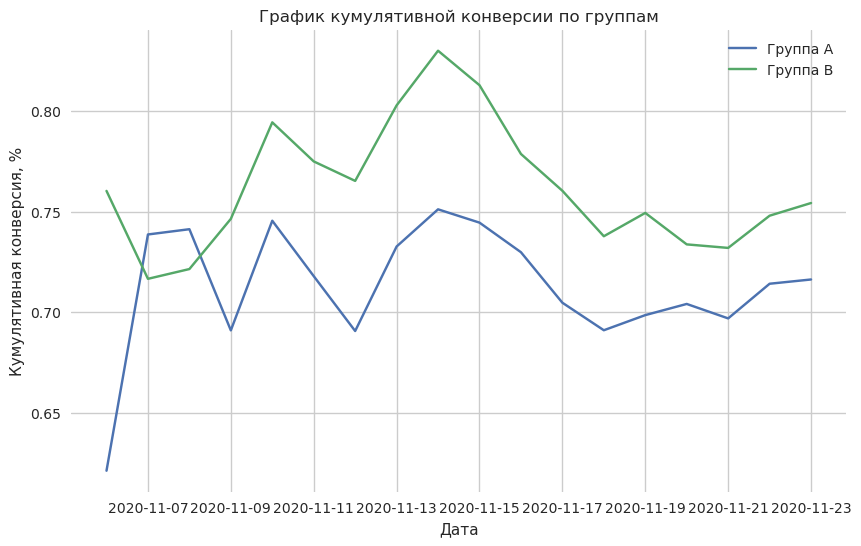

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Создаём фигуру для графика
plt.figure(figsize=(10, 6))

# Строим графики кумулятивной конверсии
plt.plot(daily_sample_a.index, daily_sample_a['cum_conversion'], label='Группа A')
plt.plot(daily_sample_b.index, daily_sample_b['cum_conversion'], label='Группа B')

# Настраиваем график
plt.title('График кумулятивной конверсии по группам')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная конверсия, %')
plt.legend()
plt.grid(True)

# Отображаем график
plt.show()


Правильный ответ: 

C. Начиная с 9 ноября 2020 года конверсии в группах имеют приблизительно идентичное поведение (одинаковые точки роста и спада). При этом конверсия в группе B стабильно выше конверсии в группе A на данном периоде.

Пояснение по графику:

Действительно, если посмотреть на график после 2020-11-09 (9 ноября), линии движутся практически синхронно: когда растет одна, растет и другая, когда падает одна — падает и вторая.
При этом зеленая линия (Группа B) на всем этом промежутке находится выше синей линии (Группа A), что говорит о стабильно лучшей конверсии в тестовой группе после начального периода стабилизации.

### Задание 4.9

1 point possible (graded)

Постройте графики кумулятивного среднего чека в каждой группе. 

Какие выводы по ним вы можете сделать?

A. Средний чек в группе B стабильно выше среднего чека в группе A на всём промежутке времени.

B. В начале периода наблюдения средний чек в группе B был меньше, чем средний чек в группе A. Однако при стабилизации метрик наблюдается обратный результат.

C. В начале периода наблюдения средний чек в группе A был меньше, чем средний чек в группе B. Однако при стабилизации метрик наблюдается обратный результат.

D. Никаких выводов сделать нельзя.



### Решение Задания 4.9

Графики кумулятивного среднего чека по группам.

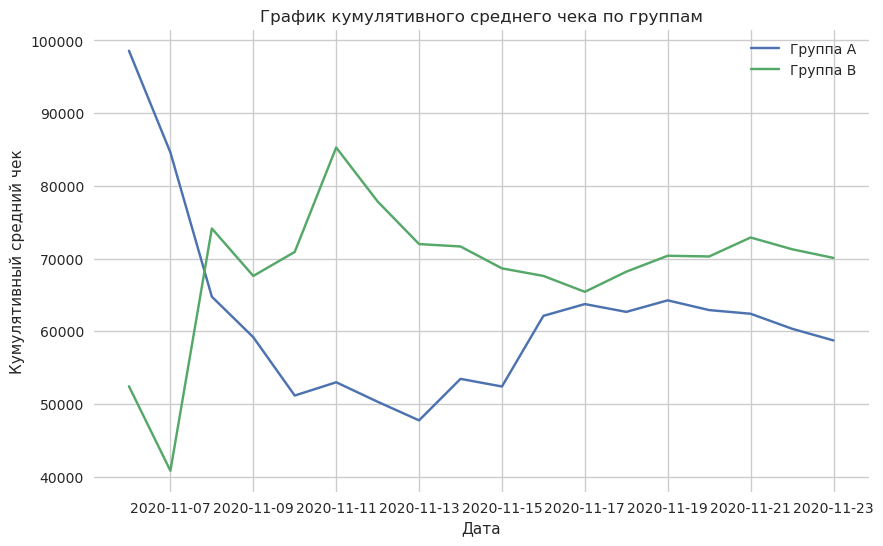

In [29]:
# Создаём фигуру для графика
plt.figure(figsize=(10, 6))

# Строим графики кумулятивного среднего чека
plt.plot(daily_sample_a.index, daily_sample_a['cum_avg_check'], label='Группа A')
plt.plot(daily_sample_b.index, daily_sample_b['cum_avg_check'], label='Группа B')

# Настраиваем график
plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Кумулятивный средний чек')
plt.legend()
plt.grid(True)

# Отображаем график
plt.show()


Правильный ответ: 

B. В начале периода наблюдения средний чек в группе B был меньше, чем средний чек в группе A. Однако при стабилизации метрик наблюдается обратный результат.

Разбор графика:

Начало периода (первые дни): Синяя линия (Группа A) находится значительно выше зеленой линии (Группа B). Средний чек в группе A достигает пика около 98 000, в то время как в группе B он около 52 000.
Период стабилизации: После резкого падения в группе A и роста в группе B, примерно с 8-9 ноября, зеленая линия (Группа B) пересекает синюю и далее стабильно держится выше неё. К концу периода средний чек группы B (около 70 000) заметно превышает средний чек группы A (около 60 000).
Это классический пример того, почему важно смотреть на кумулятивные метрики в динамике и дожидаться их стабилизации, так как начальные данные могут быть шумными и не отражать реальной картины.

## 5. Анализ результатов A/B-тестирования: статистические тесты

Сначала подготовим данные к проведению статистических тестов. Для этого нам нужно рассчитать количество пользователей, совершивших конверсию, и общее количество пользователей в каждой контрольной и тестовой группах.

Cгруппируем таблицу ab_data по признаку группы и рассчитаем количество «успехов» (сумма по столбцу converted) и общее количество наблюдений (количество непустых значений в столбце converted) для каждой группы:

In [30]:
converted_piv= ab_data.groupby('group')['converted'].agg(
    ['sum', 'count']
)
display(converted_piv)

,sum,count
group,,
A,17467,145241
B,17238,145241


In [32]:
from statsmodels.stats.proportion import proportions_ztest

alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], #число «успехов»
    nobs=converted_piv['count'], #общее число наблюдений
    alternative='two-sided',
)
# выводим результат на экран
print('p-value: ', round(p_value, 3))
# сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

# p-value:  0.19
# У нас нет оснований отвергнуть нулевую гипотезу

p-value:  0.19
У нас нет оснований отвергнуть нулевую гипотезу


Итак, мы получили p-value = 0.19. Это больше, чем заданный уровень значимости 0.05, а значит, мы должны принять нулевую гипотезу о равенстве конверсий.

Что это значит для нас и для бизнеса?

Так как Z-тест для пропорций показал, что истинные значения конверсий в группах равны (с уровнем значимости 0.05), то для нас это значит, что альтернативная гипотеза не подтверждается статистически.

Переводим на язык бизнеса: разницы между вариантами рекомендаций сопутствующих товаров нет — они одинаково эффективны по метрике конверсии.

На основе этого вывода мы принимаем решение о том, что делать дальше.

Возможные варианты:

- отказаться от внедрения ML-модели для рекомендаций сопутствующих товаров и оставить текущую версию рекомендаций;
- попытаться усовершенствовать модель и провести тестирование снова;
- использовать оба варианта системы рекомендаций и посмотреть на результат в более долгосрочной перспективе.

А что, если мы хотим уточнить исследование и проверить гипотезу о том, что варианты А и B не просто идентичны между собой, а вариант А даже лучше варианта B по метрике конверсии? Тогда нам нужно переформулировать гипотезы таким образом, чтобы альтернативная гипотеза отражала наш бизнес-вопрос:

Нулевая (будет задавать отсутствие эффекта): конверсия в группе А меньше либо равна конверсии в группе B.

$H_0:p_a \leq p_b$

Альтернативная (будет задавать наличие эффекта): конверсия в группе А больше конверсии в группе B.

$H_1:p_a > p_b$

Тогда код будет выглядеть следующим образом:

In [33]:
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для Z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], # число «успехов»
    nobs=converted_piv['count'], # общее число наблюдений
    alternative='larger' # правосторонняя альтернативная гипотеза
)
# выводим результат на экран
print('p-value: ', round(p_value, 3))
# сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

# p-value:  0.095
# У нас нет оснований отвергнуть нулевую гипотезу

p-value:  0.095
У нас нет оснований отвергнуть нулевую гипотезу


Итак, p-value = 0.095 вновь больше, чем уровень значимости 0.05. А значит, что статистика говорит нам о том, что вариант A все таки не лучше, чем вариант B, что, в принципе, было ожидаемым из предыдущего тестирования о равенстве конверсий.

### $\chi^2$ -ТЕСТ ДЛЯ ПРОПОРЦИЙ


Этот тест основан на уже знакомом нам $\chi^2$-критерии, который мы применяли для тестирования гипотезы о независимости двух категориальных признаков. Оказывается, этот же критерий с небольшими модификациями можно использовать и для установления статистической значимости разницы между пропорциями.

Этот тест применяется только для двусторонних гипотез:

Нулевая гипотеза: разница пропорций в группах A и B равна некоторому заранее заданному числу $value$: 

$H_0: p_A - p_B = value$

Альтернативная гипотеза: разница пропорций в группах A и B не равна $value$: 

$H_1: p_A - p_B \neq value$

По умолчанию $value=0$, соответственно, проверяется нулевая гипотеза равенства между истинными пропорциями $p_A$ и $p_B$ против альтернативной гипотезы об их неравенстве.

Тестом не предусмотрена возможность проверки односторонних гипотез.

$\chi^2$-тест для пропорций реализован в функции proportions_chisquare() модуля proportion библиотеки statsmodels. Импортируем его:

Давайте применим $\chi^2$-тест для пропорций на примере двух типов рекомендаций интернет-магазина с параметром value=0. То есть у нас будут две следующие конкурирующие гипотезы:

Нулевая (будет задавать отсутствие эффекта): конверсии в группах A и B равны. $H_0: p_a = p_b$

Альтернативная (будет задавать наличие эффекта): конверсии в группах A и B не равны. $H_1: p_a \neq p_b$

По умолчанию функция proportions_chisquare() возвращает $\chi^2$-статистику, p-value и таблицу сопряжённости (используется во внутренних расчётах p-value). Из всего перечня возвращаемых значений нас интересует только p-value. Занесём его в отдельную переменную для дальнейшего сравнения с уровнем значимости.

In [35]:
from statsmodels.stats.proportion import proportions_chisquare

alpha = 0.05 # уровень значимости
# вычисляем значение p-value для Z-теста для пропорций
_, p_value, c = proportions_chisquare(
    count=converted_piv['sum'], #число «успехов»
    nobs=converted_piv['count'] #общее число наблюдений
)
# выводим результат на экран
print('p-value: ', round(p_value, 3))
# сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

# p-value:  0.19
# У нас нет оснований отвергнуть нулевую гипотезу

p-value:  0.19
У нас нет оснований отвергнуть нулевую гипотезу


## ПАРАМЕТРИЧЕСКИЕ ТЕСТЫ

Давайте рассмотрим пример.

Мы проводим A/B-тест, чтобы оценить, влияет ли тема оформления на привлекательность сайта для пользователя. Гипотеза заключается в том, что тёмная тема более привлекательна для посетителей, поэтому их сильнее заинтересует наш сайт, следовательно, они проведут на нём больше времени. Уровень значимости равен 0.05.

Результаты тестирования представлены в этом [файле](https://docs.google.com/viewer?url=https%3A%2F%2Flms.skillfactory.ru%2Fasset-v1%3ASkillFactory%2BDST-3.0%2B28FEB2021%2Btype%40asset%2Bblock%40time_data.xlsx).

Прочитаем его:

In [37]:
time_data = pd.read_excel('data/time_data.xlsx')
display(time_data.head())

,time(A),time(B)
0,435.0,549.2
1,454.5,630.2
2,447.0,437.2
3,480.0,637.2
4,561.0,712.4


Для начала сравним среднее время в группах на глаз. Рассчитаем среднее и медианное время в каждой группе:

In [38]:
time_data[['time(A)', 'time(B)']].agg(['mean', 'median'])

,time(A),time(B)
mean,492.90,595.406667
median,482.25,600.400000


По предварительным подсчётам, среднее время, проводимое на сайте, в группе B выше, чем в группе A. Однако делать выводы ещё рано — необходимо определить статистическую значимость полученных результатов.

Затем построим гистограмму времени, которое провели на сайте пользователи в каждой из групп:

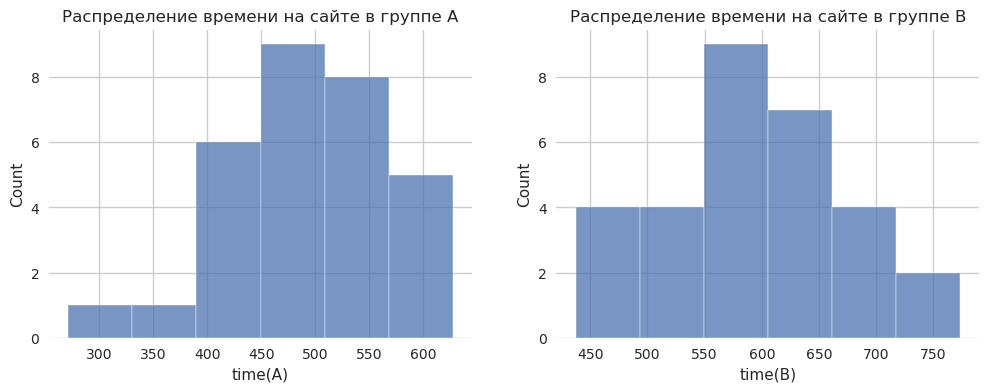

In [39]:
# создаём два графика размером 12x4
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# строим гистограмму для времени на сайте в каждой группе
sns.histplot(x='time(A)', data=time_data, ax=axes[0])
sns.histplot(x='time(B)', data=time_data, ax=axes[1])
# задаём названия графикам
axes[0].set_title('Распределение времени на сайте в группе А');
axes[1].set_title('Распределение времени на сайте в группе B');

Гистограммы напоминают нормальное распределение. Давайте проверим гипотезу о нормальности обоих распределений с помощью критерия Шапиро — Уилка. Для этого используем функцию shapiro() из модуля scipy.stats:

In [40]:
from scipy.stats import shapiro

Зададим уровень значимости $\alpha=0.05$ и проверим гипотезу о нормальности каждого из распределений (нулевая гипотеза — распределение нормальное, альтернативная — распределение отлично от нормального):

In [41]:
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро — Уилка для выборок
shapiro_result_a = shapiro(time_data['time(A)'])
shapiro_result_b = shapiro(time_data['time(B)'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))

# сравниваем полученное p-value для группы А с уровнем значимости
if shapiro_result_a.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе А отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе А является нормальным")

# сравниваем полученное p-value для группы B с уровнем значимости
if shapiro_result_b.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе B отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе B является нормальным")

# p-value группы А 0.43
# p-value группы B 0.12
# Принимаем нулевую гипотезу. Распределение в группе А является нормальным
# Принимаем нулевую гипотезу. Распределение в группе B является нормальным

p-value группы А 0.43
p-value группы B 0.12
Принимаем нулевую гипотезу. Распределение в группе А является нормальным
Принимаем нулевую гипотезу. Распределение в группе B является нормальным


Итак, распределение в обеих группах нормальное, а значит, мы можем воспользоваться T-тестом, чтобы сравнить среднее время посещения сайта в группах.


Напомним формулировки статистических гипотез для T-теста:

Нулевая гипотеза (об отсутствии эффекта): среднее время, которое проводят на сайте пользователи из группы А, равно среднему времени, которое проводят на сайте пользователи из группы B:

$H_0: \mu_A = \mu_B$

Альтернативная гипотеза (об наличии эффекта): среднее время, которое проводят на сайте пользователи из группы А, не равно среднему времени, которое проводят на сайте пользователи из группы B:

$H_1: \mu_A \neq \mu_B$ 

Примечание. Ещё раз обратите внимание на то, что именно альтернативная гипотеза отвечает на бизнес-вопрос «Увеличилось ли время, которое пользователь проводит на сайте, после внедрения варианта B?».

Применим двухвыборочный T-тест для сравнения средних — функцию ttest_ind() из модуля scipy.stats.


In [42]:
from scipy.stats import ttest_ind

Функция принимает на вход следующие параметры:

a и b — выборки, соответствующие каждой из групп.
alternative — вид альтернативной гипотезы (‘two-sided’ — двусторонняя, 'less' — левосторонняя, 'greater’ — правосторонняя). По умолчанию используется двусторонняя гипотеза.
equal_var — параметр, определяющий, является ли дисперсия выборок одинаковой. Если True, то используется тест Стьюдента для выборок с одинаковой дисперсией, если False, то используется тест Стьюдента для выборок с разной дисперсией. По умолчанию используется True.

Возвращает:

p-value — вероятность получить выборки, если нулевая гипотеза верна.

In [43]:
alpha = 0.05 #уровень значимости
# вычисляем результат T-теста для выборок
results = ttest_ind(
    a=time_data['time(A)'],
    b=time_data['time(B)'],
    alternative='two-sided'
)
print('p-value:', round(results.pvalue, 2))

# сравниваем полученное p-value с уровнем значимости
if results.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

# p-value: 0.0
# Отвергаем нулевую гипотезу в пользу альтернативной

p-value: 0.0
Отвергаем нулевую гипотезу в пользу альтернативной


Итак, в результате проведения T-теста мы получили p-value = 0, что меньше, чем уровень значимости $\alpha = 0.05$. Это значит, что мы отвергаем нулевую гипотезу в пользу альтернативной.

Что это значит для нас и для бизнеса?

Так как истинные значения конверсий в группах не равны (с уровнем значимости 0.05), то для нас это значит, что альтернативная гипотеза подтверждается статистически.

Переводим на язык бизнеса: существует разница между вариантами дизайна сайта по метрике времени, которое пользователь проводит на сайте. На основе данных мы видим, что тёмная тема более привлекательна для посетителей, чем светлая.

Обратите внимание: так как при двусторонней гипотезе p-value = 0, не нужно проверять одностороннюю гипотезу о том, что среднее время, которое проводят на сайте пользователи из группы A, меньше, чем среднее время для пользователей из группы B. Мы можем сделать итоговый вывод об этом только на основе данных, ведь мы доказали статистическую значимость разницы в метриках. Однако при желании вы можете проверить одностороннюю гипотезу самостоятельно — для этого в функции установите параметр alternative='less'.



In [44]:
alpha = 0.05 #уровень значимости
# вычисляем результат T-теста для выборок
results = ttest_ind(
    a=time_data['time(A)'],
    b=time_data['time(B)'],
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))

# сравниваем полученное p-value с уровнем значимости
if results.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

# p-value: 0.0
# Отвергаем нулевую гипотезу в пользу альтернативной

p-value: 0.0
Отвергаем нулевую гипотезу в пользу альтернативной


## НЕПАРАМЕТРИЧЕСКИЕ ТЕСТЫ

Давайте рассмотрим ещё один пример.

Мы проводим A/B-тест, чтобы оценить, влияет ли наличие рекомендательной системы сопутствующих товаров на средний чек покупки. Гипотеза заключается в том, что рекомендательная система мотивирует пользователей, помимо основных товаров, добавлять в покупку сопутствующие, тем самым повышая средний чек. Уровень значимости равен 0.05.

Результаты тестирования представлены в этом [файле](https://lms.skillfactory.ru/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block@check_data.xlsx).


In [45]:
check_data = pd.read_excel('data/check_data.xlsx')
check_data.head()

,date,mean_check_a,mean_check_b
0,2020-11-06,68701.239649,88665.123322
1,2020-11-07,26136.309375,46230.394893
2,2020-11-08,119470.770656,139356.451490
3,2020-11-09,71110.880188,90867.073191
4,2020-11-10,85896.024022,105977.473589


В данных содержится информация о значениях ежедневного среднего чека в группах A и B. Период проведения A/B-тестирования — 18 дней.

Сначала сравним среднее время в группах на глаз. Рассчитаем среднее и медианное время в каждой группе:

check_data.groupby('group').agg({'mean_check': ['mean', 'median']})

In [46]:
check_data[['mean_check_a', 'mean_check_b']].agg(['mean', 'median'])

,mean_check_a,mean_check_b
mean,76684.763071,96658.897304
median,62883.707793,82854.201467


По предварительным подсчётам, ежедневный средний чек в группе B выше, чем в группе A. Однако делать выводы ещё рано — необходимо определить статистическую значимость полученных результатов.

Построим гистограмму ежедневного среднего чека в каждой из групп:

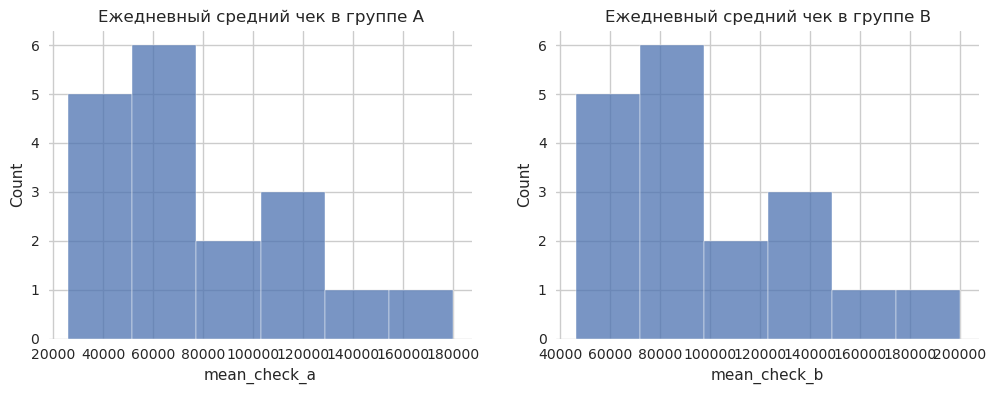

In [47]:
# создаём два графика размером 12x4
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# строим гистограмму для времени на сайте в каждой группе
sns.histplot(x='mean_check_a', data=check_data, ax=axes[0])
sns.histplot(x='mean_check_b', data=check_data, ax=axes[1])
# задаём названия графикам
axes[0].set_title('Ежедневный средний чек в группе А');
axes[1].set_title('Ежедневный средний чек в группе B');

In [ ]:
# проверка распределения на нормальность с помощью теста Шапиро — Уилка
check_data

Распределения не являются нормальными. Можно проверить это с помощью теста Шапиро — Уилка, однако мы опустим этот шаг (при желании вы можете сделать это самостоятельно). Формы распределений больше напоминают логнормальные: большинство наблюдений сосредоточено около нуля, и частота постепенно падает.

### Проверка нормальности распределения среднего чека (Тест Шапиро-Уилка)

In [48]:
from scipy.stats import shapiro

# Проверка нормальности для группы А
shapiro_result_a = shapiro(check_data['mean_check_a'])
print('Группа А (mean_check_a):')
print(f'p-value = {shapiro_result_a.pvalue:.4f}')

# Проверка нормальности для группы B
shapiro_result_b = shapiro(check_data['mean_check_b'])
print('Группа B (mean_check_b):')
print(f'p-value = {shapiro_result_b.pvalue:.4f}')

# Интерпретация результата
alpha = 0.05
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("\nОтвергаем нулевую гипотезу: распределение в одной или обеих группах отличается от нормального.")
else:
    print("\nНе удалось отвергнуть нулевую гипотезу: распределение в обеих группах нормальное (или близкое к нему).")


Группа А (mean_check_a):
p-value = 0.0473
Группа B (mean_check_b):
p-value = 0.0464

Отвергаем нулевую гипотезу: распределение в одной или обеих группах отличается от нормального.


Итак, поскольку данные не распределены нормально, для сравнения истинных средних чеков T-тест уже нё подойдет. Здесь нам придётся обратиться к непараметрическим тестам, например, к критерию Манна — Уитни (U-тест), критерию Колмогорова — Смирнова и другим. Напомним, что эта категория тестов применяется в случаях, когда нет информации о распределении.

В учебных целях мы будем использовать U-критерий Манна — Уитни для случаев, когда метрики не распределены нормально. Однако при этом будем помнить, что результатам этого критерия при p-value, близким к уровню значимости, доверять не стоит.

Давайте воспользуемся тестом Манна — Уитни, чтобы проверить, статистически значима ли разница ежедневных средних чеков для двух вариантов рекомендательной системы.

Для критерия Манна — Уитни гипотезы будут выглядеть следующим образом:

Нулевая гипотеза (об отсутствии эффекта): распределение, лежащее в основе среднего чека в группе А, идентично распределению, лежащему в основе среднего чека в группе B: $H_0: F_a(u) = F_b(u)$

Альтернативная гипотеза (об наличии эффекта): распределение, лежащее в основе среднего чека в группе А, отличается от распределения, лежащего в основе среднего чека в группе B: $H_1: F_a(u) \neq F_b(u)$

Напомним, что U-тест Манна — Уитни реализован в функции mannwhitneyu() из модуля scipy.stats.

In [49]:
from scipy.stats import mannwhitneyu

Функция принимает на вход следующие параметры:

x и y — выборки, соответствующие каждой из групп.
alternative — вид альтернативной гипотезы (‘two-sided’ — двусторонняя, 'less' — левосторонняя, 'greater’ — правосторонняя). По умолчанию используется двусторонняя гипотеза.

In [50]:
alpha = 0.05 # уровень значимости

# вычисляем результат теста Манна — Уитни для выборок
results = mannwhitneyu(
    x=check_data['mean_check_a'],
    y=check_data['mean_check_b'],
    alternative='two-sided'
)
print('p-value:', round(results.pvalue, 2))

# сравниваем полученное p-value с уровнем значимости
if results.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

# p-value: 0.06
# У нас нет оснований отвергнуть нулевую гипотезу

p-value: 0.06
У нас нет оснований отвергнуть нулевую гипотезу


Итак, согласно результатам тестирования, p-value = 0.06, что больше, чем уровень значимости $\alpha = 0.05$. Значит, у нас нет оснований отвергнуть нулевую гипотезу.


Что это значит для нас и для бизнеса?

Средние чеки в группах А и B статистически равны между собой. Отсюда можно сделать бизнес-вывод, что рекомендательная система не влияет на мотивацию пользователей добавлять сопутствующие товары в корзину.

Однако нас должно насторожить, что p-value очень близко к уровню значимости. Поэтому давайте дополнительно проведём односторонний U-тест со следующими гипотезами:

Нулевая гипотеза (об отсутствии эффекта): распределение, лежащее в основе среднего чека в группе А, статистически больше либо равно распределению, лежащему в основе среднего чека в группе B: $H_0: F_a(u) \geq F_b(u)$

Альтернативная гипотеза (об наличии эффекта): распределение, лежащее в основе среднего чека в группе А, статистически меньше распределения, лежащего в основе среднего чека в группе B: $H_1: F_a(u) < F_b(u)$


In [51]:
alpha = 0.05 # уровень значимости

# вычисляем результат теста Манна — Уитни для выборок
results = mannwhitneyu(
    x=check_data['mean_check_a'],
    y=check_data['mean_check_b'],
    alternative='less' # изменили альтернативную гипотезу
)
print('p-value:', round(results.pvalue, 2))

# сравниваем полученное p-value с уровнем значимости
if results.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

# p-value: 0.03
# Отвергаем нулевую гипотезу в пользу альтернативной

p-value: 0.03
Отвергаем нулевую гипотезу в пользу альтернативной


Получаем значение p-value = 0.03, что меньше, чем уровень значимости . Значит, мы должны отвергнуть нулевую гипотезу в пользу альтернативной. Таким образом, односторонний тест говорит нам, что разница в средних чеках всё-таки статистически значима. То есть рекомендательная система всё-таки мотивирует пользователей добавлять сопутствующие товары в корзину и повышает средний чек, а значит, её можно внедрять для всех пользователей сайта.

Итак, мы получили два противоречивых вывода: двусторонний тест говорит, что эффекта нет, а односторонний — что есть. Какой вывод правильный?

**ОТВЕТ**

На самом деле никакой. Когда двусторонний и односторонний тесты противоречат друг другу, это, скорее всего, означает, что данные неоднозначны и нужно более внимательно исследовать результаты тестирования.

В такой ситуации для более точной оценки эффекта можно попробовать провести анализ данных с помощью других методов и моделей. Также стоит обратить внимание на размер выборки, возможные выбросы, несбалансированность групп, а также на то, были ли учтены все факторы, которые могут влиять на результаты тестирования.

В нашем случае очевидной проблемой является размер выборки, а точнее длительность A/B-теста. Замеры среднего чека сделаны только за 18 дней, что очень мало. Размер выборки играет важную роль, особенно при применении непараметрических тестов (каким является тест Манна — Уитни), которые обладают меньшей мощностью, чем параметрические, а потому требуют большего количества наблюдений.

Таким образом, в данном случае мы не можем принять решение о внедрении или невнедрении рекомендательной системы, так как у нас попросту недостаточно данных, чтобы сделать вывод. Необходимо продолжить A/B-тестирование, чтобы получить однозначные результаты.

Итак, мы разобрались, как применять статистические тесты для анализа результатов A/B-тестирования, рассмотрели примеры использования разных статистических тестов и обсудили их тонкости. В следующем юните мы узнаем, как для этих же целей использовать ещё один статистический инструмент, а именно доверительные интервалы.

Стоит отметить, что для всех приведённых ранее примеров мы принимали решение, исходя только из одной бизнес-метрики, так как другими мы и не обладали. В финальном задании модуля мы проведём комплексный анализ результатов A/B-тестирования по нескольким метрикам. А пока предлагаем вам решить несколько задач.

---

Для решения следующих заданий используйте наборы данных sample_a и sample_b из предыдущего юнита (перед заданием 4.6), где приведены результаты A/B-тестирования двух вариантов дизайна одного и того же сайта.

``` python
sample_a = pd.read_csv('data/ab_test-redesign_sample_a.csv')
sample_b = pd.read_csv('data/ab_test-redesign_sample_b.csv')

# преобразуем тип столбца date к типу datetime
sample_a['date'] = pd.to_datetime(sample_a['date'])
sample_b['date'] = pd.to_datetime(sample_b['date'])
```


In [52]:
sample_a = pd.read_csv('data/ab_test-redesign_sample_a.zip')
sample_b = pd.read_csv('data/ab_test-redesign_sample_b.zip')

# преобразуем тип столбца date к типу datetime
sample_a['date'] = pd.to_datetime(sample_a['date'])
sample_b['date'] = pd.to_datetime(sample_b['date'])

### Задание 5.2

1 point possible (graded)

С помощью Z-теста для пропорций проанализируйте результаты проведённого A/B-тестирования и определите, какой из вариантов дизайна (A или B) более предпочтителен по метрике конверсии. В качестве уровня значимости возьмите alpha = 0.05. Используйте функцию proportions_ztest() из модуля statsmodels.stats.proportion.

Какой вывод можно сделать на основании результатов тестирования?


Вариант A более предпочтителен, чем вариант B, по метрике конверсии.
Вариант A менее предпочтителен, чем вариант B, по метрике конверсии.
Варианты A и B равнозначны по метрике конверсии.
Нельзя сделать однозначный вывод.



Примечание:
``` python
sample_a = pd.read_csv('data/ab_test-redesign_sample_a.zip')
sample_b = pd.read_csv('data/ab_test-redesign_sample_b.zip')

# преобразуем тип столбца date к типу datetime
sample_a['date'] = pd.to_datetime(sample_a['date'])
sample_b['date'] = pd.to_datetime(sample_b['date'])
```

Подсказка (1 из 1): В функцию необходимо передать три параметра:
count — список из общего числа транзакций в группах A и B (суммы по столбцам transactions);
nobs — число наблюдений в группах A и B (количество значений в столбце cid);
alternative — в качестве значения необходимо взять 'smaller'.


### Решение Задания 5.2 (Z-тест для конверсии)

Проверка статистической значимости разницы конверсии между группами A и B с помощью Z-теста.
Используем параметр `alternative='smaller'`, чтобы проверить гипотезу о том, что конверсия в группе А меньше, чем в группе B.

In [54]:
from statsmodels.stats.proportion import proportions_ztest

# Рассчитываем количество успехов (транзакций) и наблюдений (посетителей)
successes_a = sample_a['transactions'].sum()
nobs_a = sample_a['cid'].count()

successes_b = sample_b['transactions'].sum()
nobs_b = sample_b['cid'].count()

print(f"Группа A: Успехи={successes_a}, Наблюдения={nobs_a}, Конв={successes_a/nobs_a:.4f}")
print(f"Группа B: Успехи={successes_b}, Наблюдения={nobs_b}, Конв={successes_b/nobs_b:.4f}")

# Z-тест с параметром alternative='smaller'
alpha = 0.05
stat, p_value = proportions_ztest(count=[successes_a, successes_b], nobs=[nobs_a, nobs_b], alternative='smaller')

print(f"Z-статистика: {stat:.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < alpha:
    print("Отвергаем нулевую гипотезу: Конверсия в группе A статистически значимо меньше, чем в группе B.")
    print("Вывод: Вариант B лучше.")
else:
    print("Не удалось отвергнуть нулевую гипотезу.")
    print("Вывод: Нет оснований считать, что вариант B лучше варианта A (варианты равнозначны).")


Группа A: Успехи=441, Наблюдения=61571, Конв=0.0072
Группа B: Успехи=463, Наблюдения=61383, Конв=0.0075
Z-статистика: -0.7806
p-value: 0.2175
Не удалось отвергнуть нулевую гипотезу.
Вывод: Нет оснований считать, что вариант B лучше варианта A (варианты равнозначны).


Давайте вычислим ежедневный средний чек — это ежедневная сумма заказов, делённая на ежедневную сумму транзакций:

In [55]:
daily_sample_a = sample_a.groupby('date')[['transactions', 'revenue']].sum()
daily_sample_a['mean_check'] = daily_sample_a['revenue']/daily_sample_a['transactions']
daily_sample_b = sample_b.groupby('date')[['transactions', 'revenue']].sum()
daily_sample_b['mean_check'] = daily_sample_b['revenue']/daily_sample_a['transactions']

### Задание 5.3

1 point possible (graded)
Проверьте гипотезу о нормальности распределений ежедневного среднего чека в контрольной и тестовой группах с помощью критерия Шапиро — Уилка. В качестве уровня значимости возьмите .

Каковы результаты тестирования?


- Распределения в обеих группах являются нормальными.

- Распределения в одной или обеих группах отличны от нормального.


### Решение Задания 5.3 (Проверка нормальности среднего чека)

Проверка нормальности распределений ежедневного среднего чека в группах с помощью теста Шапиро-Уилка.

In [56]:
from scipy.stats import shapiro

# Рассчитываем ежедневный средний чек (сумма выручки / сумма транзакций за день)
daily_revenue_a = sample_a.groupby('date')['revenue'].sum()
daily_transactions_a = sample_a.groupby('date')['transactions'].sum()
daily_mean_check_a = daily_revenue_a / daily_transactions_a

daily_revenue_b = sample_b.groupby('date')['revenue'].sum()
daily_transactions_b = sample_b.groupby('date')['transactions'].sum()
daily_mean_check_b = daily_revenue_b / daily_transactions_b

print(f"Средний чек по дням. Группа А: \n{daily_mean_check_a.values}")
print(f"Средний чек по дням. Группа B: \n{daily_mean_check_b.values}")

# Тест Шапиро-Уилка
stat_a, p_a = shapiro(daily_mean_check_a)
stat_b, p_b = shapiro(daily_mean_check_b)

print(f"Группа A Shapiro: p-value={p_a:.4f}")
print(f"Группа B Shapiro: p-value={p_b:.4f}")

alpha = 0.05
if p_a < alpha or p_b < alpha:
    print("Вывод: Распределения в одной или обеих группах отличны от нормального.")
else:
    print("Вывод: Распределения в обеих группах являются нормальными.")


Средний чек по дням. Группа А: 
[ 98579.9375      74864.60869565  33842.04        39379.44444444
  28516.68965517  63666.10526316  31991.52631579  37189.33333333
  88642.56666667  44072.96296296 140459.13333333  84728.23809524
  46965.05        83337.15384615  44798.96        52203.88888889
  36528.06060606  33010.53846154]
Средний чек по дням. Группа B: 
[ 52455.          29236.78947368 126868.41666667  51433.44
  80490.86666667 161623.95454545  36626.12        46039.86486486
  69705.82352941  42486.81481481  57544.44444444  41123.07692308
 116692.16666667  95523.24137931  67990.         117557.59090909
  52348.26470588  52843.53333333]
Группа A Shapiro: p-value=0.0099
Группа B Shapiro: p-value=0.0217
Вывод: Распределения в одной или обеих группах отличны от нормального.


### Задание 5.4
1 point possible (graded)
С помощью критерия Манна — Уитни проанализируйте результаты проведённого A/B-тестирования и определите, какой из вариантов дизайна (A или B) более предпочтителен по метрике ежедневного среднего чека. В качестве уровня значимости возьмите $\alpha = 0.05$. Используйте функцию mannwhitneyu() из модуля scipy.stats.

Каков результат тестирования?


- Вариант А более предпочтителен, чем вариант B, по метрике ежедневного среднего чека.
- Варианты А и B равнозначны по метрике ежедневного среднего чека.
- Вариант А менее предпочтителен, чем вариант B, по метрике ежедневного среднего чека.
- Нельзя сделать однозначный вывод.


### Решение Задания 5.4 (Критерий Манна-Уитни)

Сравнение ежедневного среднего чека в группах А и B с помощью критерия Манна-Уитни.

In [57]:
from scipy.stats import mannwhitneyu

# Используем ранее рассчитанные daily_mean_check_a и daily_mean_check_b

print(f"Медиана среднего чека Группа A: {daily_mean_check_a.median():.2f}")
print(f"Медиана среднего чека Группа B: {daily_mean_check_b.median():.2f}")

# Тест Манна-Уитни
alpha = 0.05
stat, p_value = mannwhitneyu(daily_mean_check_a, daily_mean_check_b)

print(f"Статистика U: {stat:.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < alpha:
    print("Отвергаем нулевую гипотезу: Между группами есть значимая разница.")
    if daily_mean_check_a.median() < daily_mean_check_b.median():
        print("Вывод: Вариант A менее предпочтителен, чем вариант B (чек в B выше).")
    else:
        print("Вывод: Вариант A более предпочтителен, чем вариант B.")
else:
    print("Не удалось отвергнуть нулевую гипотезу: Варианты А и B равнозначны по метрике ежедневного среднего чека.")


Медиана среднего чека Группа A: 45882.01
Медиана среднего чека Группа B: 55193.99
Статистика U: 119.0000
p-value: 0.1787
Не удалось отвергнуть нулевую гипотезу: Варианты А и B равнозначны по метрике ежедневного среднего чека.
